<img src="zona_jobs.png">

# Trabajo Práctico N° 1: Análisis Exploratorio


## 1. Preparación de los datos

### 1.1. Importación de Librerías

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from dateutil.parser import parse
import numpy as np
import warnings
import datetime as dt
import cufflinks as cf
import plotly.plotly as py
warnings.filterwarnings('ignore')
import plotly
plotly.tools.set_credentials_file(username='soyarielruiz', api_key='Io0U7KvMLYpCw01a1vNJ')
cf.set_config_file(offline=False, world_readable=True, theme='pearl')

### 1.2. Carga de Archivos

In [2]:
# Carga de archivos
post_educacion  = pd.read_csv('../data/fiuba_1_postulantes_educacion.csv', dtype = {
    'nombre': 'category',
    'estado': 'category'
})
post_gen_edad   = pd.read_csv('../data/fiuba_2_postulantes_genero_y_edad.csv', dtype = {
    'sexo': 'category'    
})

vistas          = pd.read_csv('../data/fiuba_3_vistas.csv'       , parse_dates=['timestamp'])
postulaciones   = pd.read_csv('../data/fiuba_4_postulaciones.csv', parse_dates=['fechapostulacion'])
avisos_online   = pd.read_csv('../data/fiuba_5_avisos_online.csv')

avisos_detalles = pd.read_csv('../data/fiuba_6_avisos_detalle.csv', dtype= {
    'nombre_zona': 'category',
    'ciudad': 'category',
    'tipo_de_trabajo': 'category',
    'nivel_laboral': 'category',
})

### 1.3. Ajustes de los Archivos antes de procesar

In [3]:
# Recorto la columna idpais ya que no es necesaria.
avisos_detalles.drop('idpais', axis=1, inplace=True)

In [4]:
# Agrupo las áreas parecidas.
areas_agrupadas = pd.read_csv('../extraData/areas_agrupadas.csv')
avisos_detalles = pd.merge(avisos_detalles, areas_agrupadas, how='inner', on='nombre_area')
avisos_detalles['nombre_area'] = avisos_detalles['nuevo_nombre_area']
avisos_detalles.drop('nuevo_nombre_area', axis=1, inplace=True)

In [5]:
# Convierto el nombre del area a category.
avisos_detalles['nombre_area'] = avisos_detalles['nombre_area'].astype('category')

In [6]:
# Agrego tipo categorico y modifico el tipo de dato de la fecha.
post_gen_edad.fechanacimiento = post_gen_edad.fechanacimiento.apply(pd.to_datetime, errors='coerce')

now = pd.Timestamp(dt.datetime.now())
pd.to_datetime(now)
post_gen_edad['edad'] = (now - pd.to_datetime(post_gen_edad['fechanacimiento'])).astype('<m8[Y]')

In [7]:
# Renombramos algunas columnas para unificar criterios.
vistas.rename(columns={"idAviso":"idaviso"}     , inplace=True)
vistas.rename(columns={"timestamp":"fechavista"}, inplace=True)

# Cambiar el tipo de dato de la fecha de vista.
vistas[['fechavista']] = vistas[['fechavista']].apply(pd.to_datetime)

### 1.4. Ajustes de los Archivos antes de procesar

#### 1.4.1 Merges necesarios

In [61]:
usuarios_detalle                             = pd.merge(post_educacion                    , post_gen_edad   , how='inner', left_on='idpostulante', right_on='idpostulante')
postulaciones_con_detalle_de_aviso           = pd.merge(postulaciones                     , avisos_detalles , how='inner', left_on='idaviso'     , right_on='idaviso')
postulaciones_con_detalle_de_aviso_y_usuario = pd.merge(postulaciones_con_detalle_de_aviso, usuarios_detalle, how='inner', left_on='idpostulante', right_on='idpostulante')
visitas_con_detalle_de_aviso                 = pd.merge(vistas                            , avisos_detalles , how='inner', left_on='idaviso'     , right_on='idaviso')
visitas_con_detalle_de_aviso_y_usuario       = pd.merge(visitas_con_detalle_de_aviso      , usuarios_detalle, how='inner', left_on='idpostulante', right_on='idpostulante')

#### 1.4.2 Busqueda de Maxima Educación

In [9]:
# Asigno puntajes a los diferentes niveles educativos encontrados para poder 
# obtener asi la educacion mas valiosa (la de nivel academico mas alto) de cada postulante.
valores_educacion = pd.DataFrame({
    'nombre': [
        'Otro',  'Otro',  'Otro',  'Secundario',  'Secundario',  'Secundario',  'Terciario/Técnico', 'Universitario',  \
        'Terciario/Técnico', 'Universitario',  'Terciario/Técnico', 'Universitario',  'Posgrado', 'Master','Posgrado', \
        'Master','Posgrado', 'Master','Doctorado','Doctorado','Doctorado'
    ],
    'estado': [
        'Abandonado', 'En Curso','Graduado','Abandonado', 'En Curso','Graduado','Abandonado', 'Abandonado', 'En Curso',\
        'En Curso','Graduado','Graduado','Abandonado', 'Abandonado', 'En Curso','En Curso','Graduado','Graduado',\
        'Abandonado', 'En Curso','Graduado'
    ],
    'valor_educacion': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
})

# Y le pongo las mismas categorias que ya habia encontrado previamente.
valores_educacion.nombre = valores_educacion.nombre.astype((pd.api.types.CategoricalDtype(post_educacion.nombre.cat.categories)))
valores_educacion.estado = valores_educacion.estado.astype((pd.api.types.CategoricalDtype(post_educacion.estado.cat.categories)))

In [10]:
# Hago el join para aplicar puntajes a las educaciones de los postulantes.
post_educacion = pd.merge(post_educacion, valores_educacion, how='inner', left_on=['nombre','estado'], right_on = ['nombre','estado'])
# Cuento cuantos registros tengo actualmente, para comprobar que no hay errores mas adelante.
# post_educacion.count()

In [11]:
# Busco la maxima educacion que tiene cada postulante.
max_post_educacion = post_educacion.groupby(['idpostulante'])['valor_educacion'].max().reset_index()
# Controlo cuantas lineas me devolvio.
# max_post_educacion.count()

In [12]:
# Hago el join para filtrar todas las educaciones que no me interesan, dejando solo la maxima educacion.
post_educacion = pd.merge(post_educacion, max_post_educacion,  how='inner', left_on=['idpostulante','valor_educacion'], right_on = ['idpostulante','valor_educacion'])
# post_educacion.count()

In [13]:
post_educacion_graph = post_educacion.groupby(['nombre', 'estado', 'valor_educacion'])['idpostulante'].count().reset_index()
post_educacion_graph['resumen'] = post_educacion_graph.nombre.astype('object') + ' ' + post_educacion_graph.estado.astype('object')
post_educacion_graph.sort_values('valor_educacion', inplace=True)
post_educacion_graph.reset_index()
post_educacion_graph.drop(['nombre', 'estado', 'valor_educacion'], axis=1, inplace=True)
post_educacion_graph.rename(columns= {'idpostulante' : 'Cantidad de Postulantes'}, inplace=True)

# post_educacion_graph.head(22)

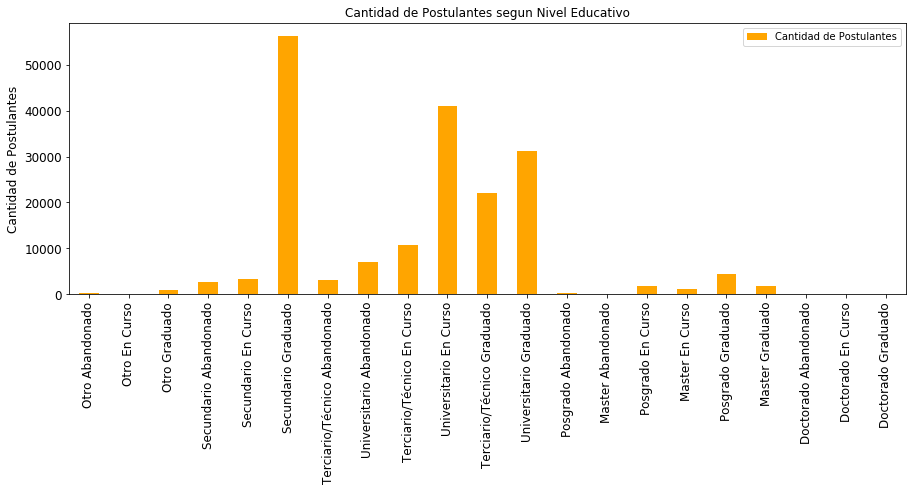

In [14]:
post_educacion_graph = post_educacion_graph[['resumen','Cantidad de Postulantes']].plot(kind='bar', x = 'resumen',                                                           
                                                           title ="Cantidad de Postulantes segun Nivel Educativo", 
                                                           figsize=(15, 5), legend=True, fontsize=12, color='orange')
post_educacion_graph.set_xlabel("", fontsize=12)
post_educacion_graph.set_ylabel("Cantidad de Postulantes", fontsize=12)
plt.show()

## 2.1. Perfil de Postulantes

In [15]:
# Generamos un perfil sobre el postulante en base a los datos que tenemos, educacion, edad.
postulantes = pd.merge(max_post_educacion, post_gen_edad)
pd.to_datetime(postulantes['fechanacimiento'])
postulantes['edad'] = (now - pd.to_datetime(postulantes['fechanacimiento'])).astype('<m8[Y]')
pd.to_numeric(postulantes['edad'])

# Dejo solo los mayores de edad y menores a la edad de jubilacion
postulantes_filtrados_por_edad = postulantes.loc[(postulantes['edad'] >= 18) & (postulantes['edad'] <= 65)].reset_index()
postulantes_filtrados_por_edad.drop('index', inplace=True, axis=1)

postulantes_filtrados_por_edad.head()

,idpostulante,valor_educacion,fechanacimiento,sexo,edad
0,0z5VvGv,6,1987-10-18,MASC,30.0
1,0zB026d,11,1978-02-23,FEM,40.0
2,0zB03O9,9,1987-07-04,FEM,30.0
3,0zB08lq,6,1972-06-09,MASC,45.0
4,0zB0NWY,12,1987-09-20,FEM,30.0


In [16]:
# Creo un nuevo DataFrame de los postulantes y el area para el cual se postulan con mas frecuencia.
postulantes_areas = pd.merge(postulaciones, avisos_detalles, how='inner', on='idaviso')
postulantes_areas = pd.DataFrame(postulantes_areas.groupby(['idpostulante', 'nombre_area'])['idaviso'].count()).reset_index()
postulantes_areas = pd.DataFrame(postulantes_areas.sort_values(['idpostulante','idaviso'], ascending=False))
postulantes_areas = postulantes_areas.groupby(['idpostulante']).first()
postulantes_areas.drop('idaviso', inplace=True, axis=1)
postulantes_areas = postulantes_areas.reset_index()

In [17]:
postulantes_filtrados_por_edad.set_index('idpostulante', inplace=True)
postulantes_areas.set_index('idpostulante', inplace=True)

postulantes_filtrados_por_edad.index.name = None
postulantes_areas.index.name = None

In [18]:
postulantes_filtrados_por_edad = pd.concat([postulantes_filtrados_por_edad, postulantes_areas], axis=1)

In [87]:
# postulantes_area_edad = postulantes_filtrados_por_edad.groupby(['nombre_area', 'edad']).count().reset_index()
# postulantes_area_edad.drop(['valor_educacion', 'fechanacimiento', 'sexo'], inplace=True, axis=1)
# postulantes_area_edad = postulantes_area_edad.groupby('nombre_area').agg(['min', 'max', 'mean'])
# postulantes_area_edad.sort_values([('edad', 'min')], inplace=True)
# postulantes_area_edad = postulantes_area_edad[postulantes_area_edad[('edad', 'min')] != postulantes_area_edad[('edad', 'max')]]
# postulantes_area_edad

#para hacer grafico de cajas.

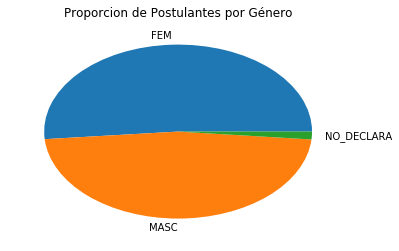

In [109]:
ax = plt.gca()
postulantes_por_genero = postulantes.groupby('sexo')['idpostulante'].count()
postulantes_por_genero.rename({'idpostulante': 'Cantidad de Postulantes'}, inplace=True)
pie = postulantes_por_genero.plot.pie(title="Proporcion de Postulantes por Género")
ax.set_xlabel('');
ax.set_ylabel('');

In [110]:
postulaciones_count = pd.merge(postulaciones, post_gen_edad, how='inner', on='idpostulante')
postulaciones_count = pd.merge(postulaciones_count, avisos_detalles, how='inner', on='idaviso')
postulaciones_count.drop(['idaviso', 'idpostulante', 'fechapostulacion', 'fechanacimiento', 'titulo', \
                          'descripcion', 'mapacalle', 'ciudad', 'denominacion_empresa'], inplace=True, axis=1)
postulaciones_count['edad_masc'] = np.where(postulaciones_count['sexo'] == 'MASC', postulaciones_count['edad'], np.NaN)
postulaciones_count['edad_fem'] = np.where(postulaciones_count['sexo'] == 'FEM', postulaciones_count['edad'], np.NaN)
postulaciones_count = postulaciones_count[postulaciones_count['edad'] <= 65] # Filtro la edad jubilatoria

postulaciones_count = postulaciones_count.groupby('s')

postulaciones_count



,sexo,edad,nombre_zona,tipo_de_trabajo,nivel_laboral,nombre_area,edad_masc,edad_fem
0,FEM,47.0,Gran Buenos Aires,Part-time,Otro,Consultoria,NaN,47.0
1,FEM,33.0,Gran Buenos Aires,Part-time,Otro,Consultoria,NaN,33.0
2,FEM,39.0,Gran Buenos Aires,Part-time,Otro,Consultoria,NaN,39.0
3,FEM,39.0,Gran Buenos Aires,Part-time,Otro,Consultoria,NaN,39.0
4,FEM,32.0,Gran Buenos Aires,Part-time,Otro,Consultoria,NaN,32.0
5,FEM,32.0,Gran Buenos Aires,Part-time,Otro,Consultoria,NaN,32.0
6,FEM,31.0,Gran Buenos Aires,Part-time,Otro,Consultoria,NaN,31.0
7,FEM,27.0,Gran Buenos Aires,Part-time,Otro,Consultoria,NaN,27.0
8,FEM,27.0,Gran Buenos Aires,Part-time,Otro,Consultoria,NaN,27.0
9,MASC,29.0,Gran Buenos Aires,Part-time,Otro,Consultoria,29.0,NaN


### 2.2. Analisis de los Avisos

#### 2.2.1 Cantidad de avisos en los diferentes niveles laborales


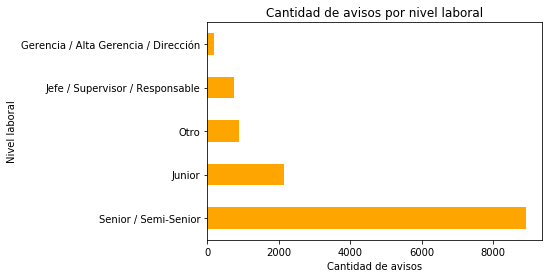

In [20]:
ax = plt.gca()
avisos_detalles.groupby('nivel_laboral')['nivel_laboral'].count().sort_values(ascending=False)\
               .plot(kind='barh', color="orange", title="Cantidad de avisos por nivel laboral");
ax.set_xlabel('Cantidad de avisos')
ax.set_ylabel('Nivel laboral');

#### 2.2.2 Cuales son las areas laborales con mayor cantidad de avisos?


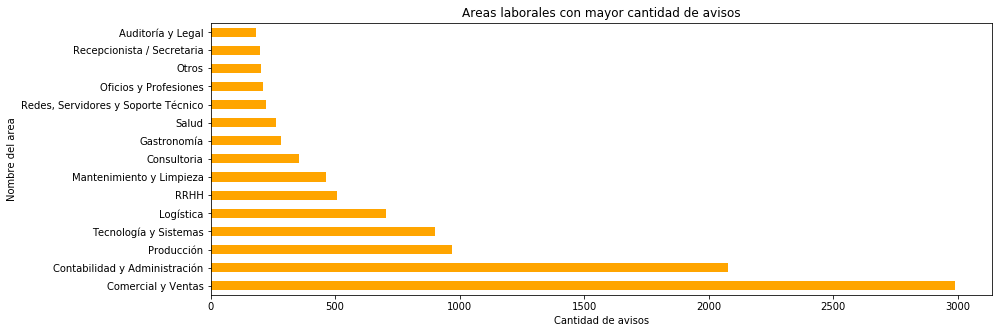

In [21]:
ax = plt.gca()
avisos_detalles.groupby('nombre_area')['nombre_area'].count().sort_values(ascending=False).head(15) \
               .plot(kind='barh', color='orange',figsize=(14,5), title="Areas laborales con mayor cantidad de avisos");
ax.set_xlabel('Cantidad de avisos');
ax.set_ylabel('Nombre del area');

#### 2.2.3 Areas Laborales con Menor Cantidad de Avisos

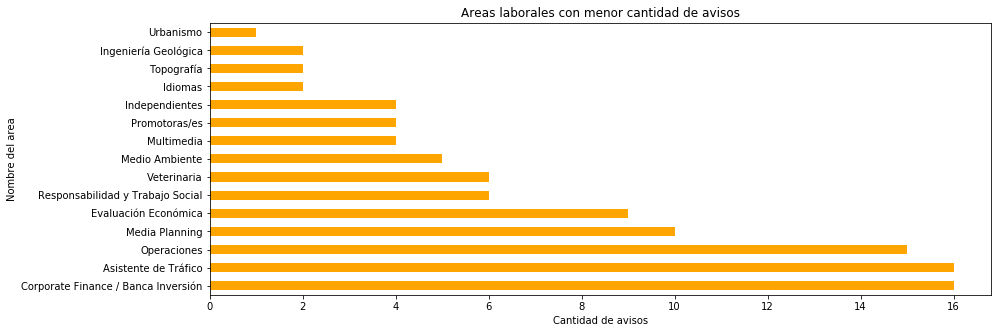

In [22]:
ax = plt.gca()
avisos_detalles.groupby('nombre_area')['nombre_area'].count().sort_values(ascending=True).head(15).sort_values(ascending=False)\
               .plot(kind='barh', figsize=(14,5), color='orange', title='Areas laborales con menor cantidad de avisos');
ax.set_xlabel('Cantidad de avisos');
ax.set_ylabel('Nombre del area');

#### 2.2.4 Cuales son las Areas Laborales con Mayor Cantidad de Postulaciones

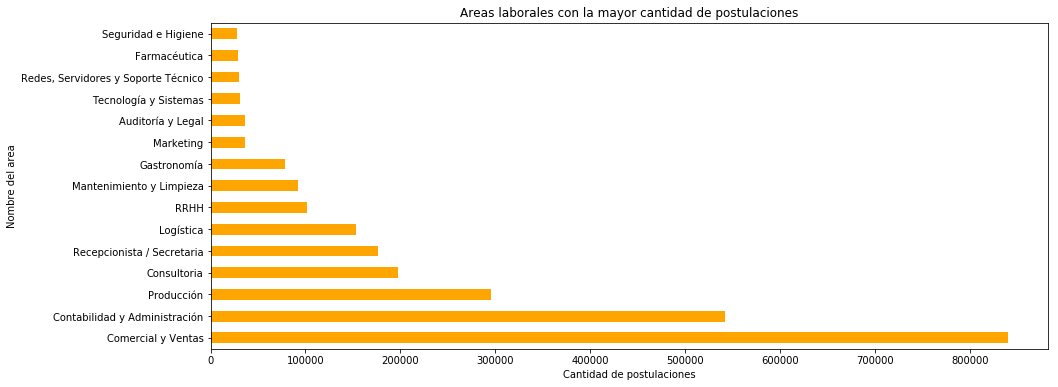

In [29]:
ax = plt.gca()
postulaciones_con_detalle_de_aviso.groupby('nombre_area')['nombre_area'].count().sort_values(ascending=False).head(15)\
                                     .plot(kind='barh', figsize=(15,6), color='orange', title='Areas laborales con la mayor cantidad de postulaciones');
ax.set_xlabel('Cantidad de postulaciones');
ax.set_ylabel('Nombre del area');

#### 2.2.5 Cuales son las Areas Laborales con Menor Cantidad de Postulacione

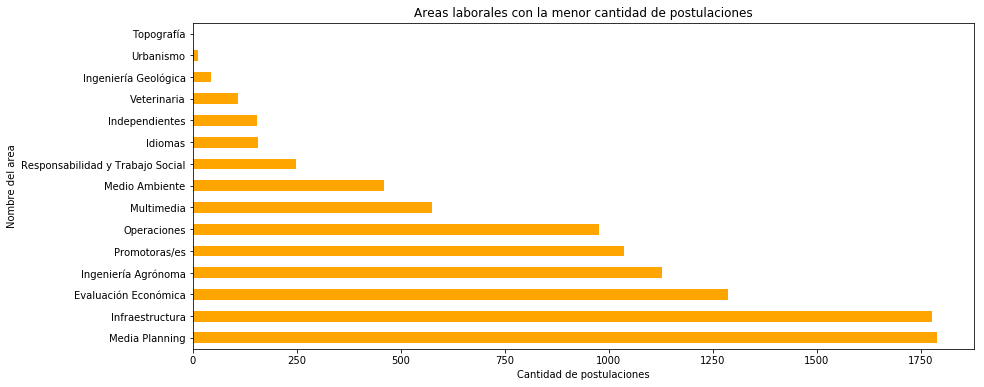

In [32]:
ax = plt.gca()
postulaciones_con_detalle_de_aviso.groupby('nombre_area')['nombre_area'].count().sort_values(ascending=True).head(15).sort_values(ascending=False)\
                                     .plot(kind='barh', figsize=(14,6), color='orange', title='Areas laborales con la menor cantidad de postulaciones');
ax.set_xlabel('Cantidad de postulaciones');
ax.set_ylabel('Nombre del area');

#### 2.2.6. Trabajos más buscados por Estudiantes Universitarios

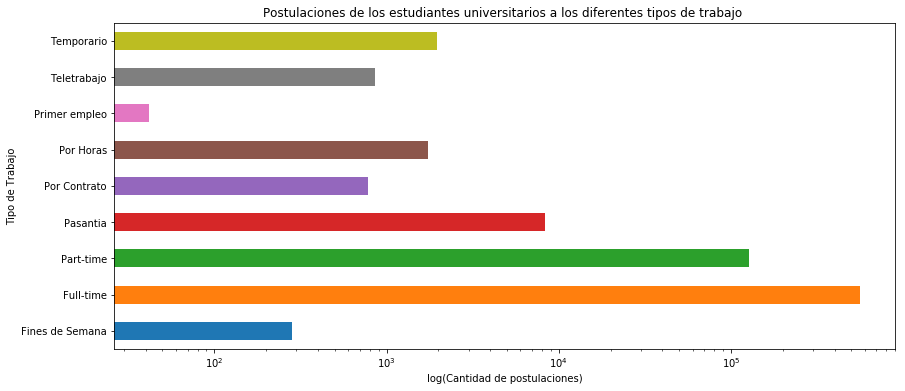

In [85]:
ax = plt.gca()

postulantes_universitarios = postulantes[postulantes['valor_educacion'] == 10]
postulantes_universitarios = pd.merge(postulantes_universitarios, postulaciones, how='inner', on='idpostulante')
postulantes_universitarios = pd.merge(postulantes_universitarios, avisos_detalles, how='inner', on='idaviso')
postulantes_universitarios = postulantes_universitarios.groupby('tipo_de_trabajo')['idpostulante'].count()

postulantes_universitarios.plot(kind='barh', figsize=(14,6), logx=True, ax=ax, \
               title='Postulaciones de los estudiantes universitarios a los diferentes tipos de trabajo ');
ax.set_xlabel('log(Cantidad de postulaciones)');
ax.set_ylabel('Tipo de Trabajo');

#### 2.2.7. Trabajos más buscados por Universitarios Graduados

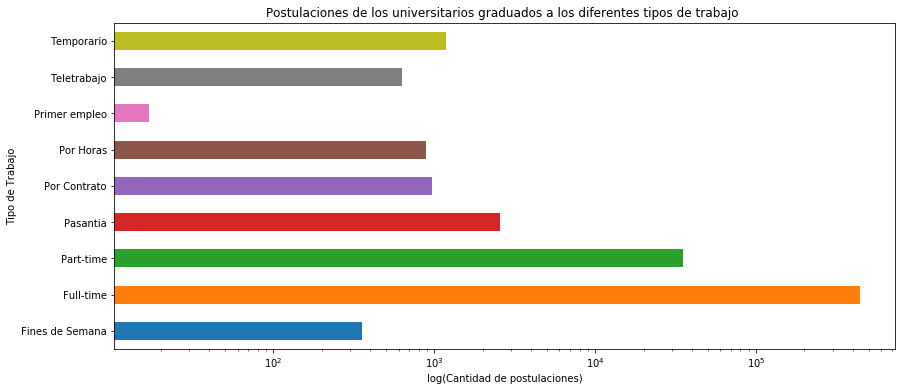

In [86]:
ax = plt.gca()

postulantes_universitarios = postulantes[postulantes['valor_educacion'] == 12]
postulantes_universitarios = pd.merge(postulantes_universitarios, postulaciones, how='inner', on='idpostulante')
postulantes_universitarios = pd.merge(postulantes_universitarios, avisos_detalles, how='inner', on='idaviso')
postulantes_universitarios = postulantes_universitarios.groupby('tipo_de_trabajo')['idpostulante'].count()

postulantes_universitarios.plot(kind='barh', figsize=(14,6), logx=True, ax=ax, \
               title='Postulaciones de los universitarios graduados a los diferentes tipos de trabajo ');
ax.set_xlabel('log(Cantidad de postulaciones)');
ax.set_ylabel('Tipo de Trabajo');

Se puede ver cómo los estudiantes universitarios cambian sus hábitos de búsqueda de trabajo hacia terrenos más estables:

* Aumenta el Teletrabajo.
* Aumenta el trabajo por contrato.

In [62]:
# postulantes['valor_educacion'] >= 12
#postulantes_universitarios[]
# postulantes_universitarios

# postulaciones_con_detalle_de_aviso_y_usuario2 = pd.merge(postulaciones_con_detalle_de_aviso_y_usuario, postulantes, on='idpostulante', how='inner')
# postulaciones_con_detalle_de_aviso_y_usuario2

,idaviso,idpostulante,fechapostulacion,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,...,nombre,estado,valor_educacion_x,fechanacimiento_x,sexo_x,edad_x,valor_educacion_y,fechanacimiento_y,sexo_y,edad_y
0,1112257047,NM5M,2018-01-15 16:22:34,REPRESENTANTES DE ATENCIÓN AL CLIENTE/ RETENCIÓN,"<p><strong><em><span style="""">En </span></em><...",Gran Buenos Aires,NaN,NaN,Part-time,Otro,...,Secundario,Graduado,6,1970-12-03,FEM,47.0,6,1970-12-03,FEM,47.0
1,1111920714,NM5M,2018-02-06 09:04:50,Telemarketers part-time para venta de tarjetas...,<p>En Randstad Argentina nos encontramos en bú...,Gran Buenos Aires,NaN,NaN,Part-time,Senior / Semi-Senior,...,Secundario,Graduado,6,1970-12-03,FEM,47.0,6,1970-12-03,FEM,47.0
2,1112346945,NM5M,2018-02-22 09:04:47,Agente de Telemarketing,"<p style="""">4 Finance, importante empresa fina...",Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,...,Secundario,Graduado,6,1970-12-03,FEM,47.0,6,1970-12-03,FEM,47.0
3,1112345547,NM5M,2018-02-22 09:04:59,Telemárketers part time,<p>En Randstad Argentina nos encontramos en bú...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,...,Secundario,Graduado,6,1970-12-03,FEM,47.0,6,1970-12-03,FEM,47.0
4,1112257047,1kJqGb,2018-01-15 10:23:11,REPRESENTANTES DE ATENCIÓN AL CLIENTE/ RETENCIÓN,"<p><strong><em><span style="""">En </span></em><...",Gran Buenos Aires,NaN,NaN,Part-time,Otro,...,Terciario/Técnico,Graduado,11,1984-04-21,FEM,33.0,11,1984-04-21,FEM,33.0
5,1112262494,1kJqGb,2018-01-17 15:02:40,OPERADORES TELEFÓNICOS DE ATENCIÓN AL CLIENTE,"<p style="""">Buscamos Operadores Telefónicos pa...",Gran Buenos Aires,NaN,NaN,Part-time,Senior / Semi-Senior,...,Terciario/Técnico,Graduado,11,1984-04-21,FEM,33.0,11,1984-04-21,FEM,33.0
6,1112262197,1kJqGb,2018-01-17 15:02:12,Operador/ra de Atención al Cliente,"<p>Importante multinacional de Seguros, busca ...",Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,...,Terciario/Técnico,Graduado,11,1984-04-21,FEM,33.0,11,1984-04-21,FEM,33.0
7,1111790454,1kJqGb,2018-01-15 10:20:29,Atención al cliente - reclamos,<p><strong>ASSIST CARD</strong></p><p> </p><p>...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,...,Terciario/Técnico,Graduado,11,1984-04-21,FEM,33.0,11,1984-04-21,FEM,33.0
8,1112245960,1kJqGb,2018-01-21 19:51:10,Encuestador telefónico,<p>Nos encontramos en la búsqueda de operadore...,Gran Buenos Aires,NaN,NaN,Part-time,Senior / Semi-Senior,...,Terciario/Técnico,Graduado,11,1984-04-21,FEM,33.0,11,1984-04-21,FEM,33.0
9,1112245073,1kJqGb,2018-01-17 15:03:04,Operador de Atención al Cliente,"<p><span lang=""ES"">ADT importante empresa mult...",Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,...,Terciario/Técnico,Graduado,11,1984-04-21,FEM,33.0,11,1984-04-21,FEM,33.0


ValueError: Must pass DataFrame with boolean values only

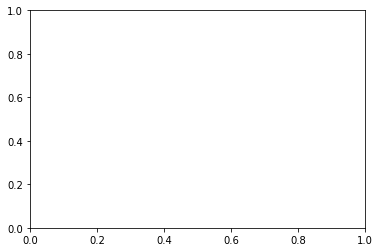

In [48]:
ax = plt.gca()

postulantes_universitarios = postulantes[postulantes['valor_educacion'] >= 12]

postulantes_universitarios = (postulaciones_con_detalle_de_aviso_y_usuario[\
    (postulaciones_con_detalle_de_aviso_y_usuario.nombre == 'Universitario') &                                                                   
    (postulaciones_con_detalle_de_aviso_y_usuario.estado == 'Graduado')
]).groupby(['tipo_de_trabajo'])['idaviso'].count() 
        
postulantes_universitarios.plot(kind='barh', figsize=(14,6), logx=True, ax=ax, \
               title='Postulaciones de los estudiantes universitarios a los diferentes tipos de trabajo ');
ax.set_xlabel('log(Cantidad de postulaciones)');
ax.set_ylabel('Tipo de Trabajo');

In [40]:
postulaciones_con_detalle_de_aviso_y_usuario

,idaviso,idpostulante,fechapostulacion,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa,nombre,estado,fechanacimiento,sexo,edad
0,1112257047,NM5M,2018-01-15 16:22:34,REPRESENTANTES DE ATENCIÓN AL CLIENTE/ RETENCIÓN,"<p><strong><em><span style="""">En </span></em><...",Gran Buenos Aires,NaN,NaN,Part-time,Otro,Consultoria,Eficasia Argentina SA,Secundario,Graduado,1970-12-03,FEM,47.0
1,1111920714,NM5M,2018-02-06 09:04:50,Telemarketers part-time para venta de tarjetas...,<p>En Randstad Argentina nos encontramos en bú...,Gran Buenos Aires,NaN,NaN,Part-time,Senior / Semi-Senior,Comercial y Ventas,RANDSTAD,Secundario,Graduado,1970-12-03,FEM,47.0
2,1112346945,NM5M,2018-02-22 09:04:47,Agente de Telemarketing,"<p style="""">4 Finance, importante empresa fina...",Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial y Ventas,Prestamo Movil,Secundario,Graduado,1970-12-03,FEM,47.0
3,1112345547,NM5M,2018-02-22 09:04:59,Telemárketers part time,<p>En Randstad Argentina nos encontramos en bú...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial y Ventas,RANDSTAD,Secundario,Graduado,1970-12-03,FEM,47.0
4,1112257047,1kJqGb,2018-01-15 10:23:11,REPRESENTANTES DE ATENCIÓN AL CLIENTE/ RETENCIÓN,"<p><strong><em><span style="""">En </span></em><...",Gran Buenos Aires,NaN,NaN,Part-time,Otro,Consultoria,Eficasia Argentina SA,Universitario,En Curso,1984-04-21,FEM,33.0
5,1112257047,1kJqGb,2018-01-15 10:23:11,REPRESENTANTES DE ATENCIÓN AL CLIENTE/ RETENCIÓN,"<p><strong><em><span style="""">En </span></em><...",Gran Buenos Aires,NaN,NaN,Part-time,Otro,Consultoria,Eficasia Argentina SA,Terciario/Técnico,Graduado,1984-04-21,FEM,33.0
6,1112262494,1kJqGb,2018-01-17 15:02:40,OPERADORES TELEFÓNICOS DE ATENCIÓN AL CLIENTE,"<p style="""">Buscamos Operadores Telefónicos pa...",Gran Buenos Aires,NaN,NaN,Part-time,Senior / Semi-Senior,Consultoria,BBVA Francés,Universitario,En Curso,1984-04-21,FEM,33.0
7,1112262494,1kJqGb,2018-01-17 15:02:40,OPERADORES TELEFÓNICOS DE ATENCIÓN AL CLIENTE,"<p style="""">Buscamos Operadores Telefónicos pa...",Gran Buenos Aires,NaN,NaN,Part-time,Senior / Semi-Senior,Consultoria,BBVA Francés,Terciario/Técnico,Graduado,1984-04-21,FEM,33.0
8,1112262197,1kJqGb,2018-01-17 15:02:12,Operador/ra de Atención al Cliente,"<p>Importante multinacional de Seguros, busca ...",Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Consultoria,Suple,Universitario,En Curso,1984-04-21,FEM,33.0
9,1112262197,1kJqGb,2018-01-17 15:02:12,Operador/ra de Atención al Cliente,"<p>Importante multinacional de Seguros, busca ...",Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Consultoria,Suple,Terciario/Técnico,Graduado,1984-04-21,FEM,33.0


In [47]:
postulantes[postulantes['valor_educacion'] >= 12]

,idpostulante,valor_educacion,fechanacimiento,sexo,edad
4,0zB0NWY,12,1987-09-20,FEM,30.0
11,0zB10m8,12,1968-08-26,MASC,49.0
12,0zB11wr,12,1984-04-04,FEM,34.0
16,0zB1J2E,16,1991-07-06,MASC,26.0
22,0zB1oA1,12,1994-02-25,FEM,24.0
36,0zB3Nz9,12,1996-06-20,MASC,21.0
40,0zB3x5M,12,1986-05-14,MASC,31.0
48,0zB4Rrd,12,1985-03-27,FEM,33.0
50,0zB4bv1,12,1988-08-15,FEM,29.0
52,0zB4jvq,15,1988-01-11,FEM,30.0


In [45]:
valores_educacion

,estado,nombre,valor_educacion
0,Abandonado,Otro,1
1,En Curso,Otro,2
2,Graduado,Otro,3
3,Abandonado,Secundario,4
4,En Curso,Secundario,5
5,Graduado,Secundario,6
6,Abandonado,Terciario/Técnico,7
7,Abandonado,Universitario,8
8,En Curso,Terciario/Técnico,9
9,En Curso,Universitario,10


In [24]:
post_educacion.head()

,idpostulante,nombre,estado,valor_educacion
0,NdJl,Posgrado,En Curso,15
1,axaPJ,Posgrado,En Curso,15
2,Z48mz,Posgrado,En Curso,15
3,a4zEZ,Posgrado,En Curso,15
4,6AWqO,Posgrado,En Curso,15


In [25]:
post_gen_edad.head()

,idpostulante,fechanacimiento,sexo,edad
0,NM5M,1970-12-03,FEM,47.0
1,5awk,1962-12-04,FEM,55.0
2,ZaO5,1978-08-10,FEM,39.0
3,NdJl,1969-05-09,MASC,48.0
4,eo2p,1981-02-16,MASC,37.0


In [26]:
vistas.head()

,idaviso,fechavista,idpostulante
0,1111780242,2018-02-23 18:38:13.187,YjVJQ6Z
1,1112263876,2018-02-23 18:38:14.296,BmVpYoR
2,1112327963,2018-02-23 18:38:14.329,wVkBzZd
3,1112318643,2018-02-23 18:38:17.921,OqmP9pv
4,1111903673,2018-02-23 18:38:18.973,DrpbXDP


In [27]:
postulaciones.head()

,idaviso,idpostulante,fechapostulacion
0,1112257047,NM5M,2018-01-15 16:22:34
1,1111920714,NM5M,2018-02-06 09:04:50
2,1112346945,NM5M,2018-02-22 09:04:47
3,1112345547,NM5M,2018-02-22 09:04:59
4,1112237522,5awk,2018-01-25 18:55:03


In [28]:
avisos.head()

NameError: name 'avisos' is not defined

In [ ]:
avisos_detalles.head()

In [ ]:
avisos_detalles.columns.values

In [ ]:
avisos_detalles.describe()

In [ ]:
#relacion avisos vs postulantes
post_avisos = pd.merge(avisos_detalles, postulaciones, on='idaviso', how='inner')
post_avisos.count()

In [ ]:
#avisos que no tienen postulantes
avisos_sin_post = pd.merge(avisos_detalles, postulaciones, on='idaviso', how='left')
avisos_sin_post = avisos_sin_post[avisos_sin_post['idpostulante'].isnull()]
avisos_sin_post.count()

In [ ]:
#avisos que tienen postulantes
avisos_con_post = avisos_detalles.merge(avisos_sin_post, how='left', on='idaviso')
avisos_con_post = avisos_con_post[avisos_con_post['titulo_y'].isnull()]
avisos_con_post.count()

In [ ]:
#avisos totales
avisos_detalles.count()

In [ ]:
avisos.count()

In [ ]:
postulaciones.count()

In [ ]:
#cantidad de postulaciones por postulante
cant_post = postulaciones.loc[:,['idpostulante']]
cant_post = cant_post.merge(post_gen_edad,how='inner',on='idpostulante')
cant_post.head()

In [ ]:
cant_post = cant_post.loc[:,['idpostulante']]
cant_post_group = cant_post.groupby(['idpostulante']).size()
cant_post_group.head()

In [ ]:
cant_post_group_sort = cant_post_group.sort_values(ascending=False)
cant_post_group_sort.head()

In [ ]:
#agrego el sexo y fechanacimiento
cant_post_sexo = pd.DataFrame(cant_post_group_sort).reset_index()
cant_post_sexo = cant_post_sexo.merge(post_gen_edad, how='inner', on='idpostulante')
cant_post_sexo[["idpostulante", "cantidad_postulaciones", "fechanacimiento", "sexo"]] = \
    cant_post_sexo[["idpostulante", 0, "fechanacimiento", "sexo"]]

cant_post_sexo= cant_post_sexo[["idpostulante", "cantidad_postulaciones", "fechanacimiento", "sexo"]]  
cant_post_sexo.head(15)